In [1]:
%matplotlib widget

from dlib import get_frontal_face_detector
from dlib import shape_predictor
from dlib import rectangle

import cv2
import os
import numpy as np
import sys
from skimage.transform import resize
import matplotlib.pyplot as plt

#from emotrics_rec import all

In [2]:
def getlandmarks(input_image, model_name):
    #function to automatically localize the landmarks in the a face image using 
    #dlib algorithm 
    detector = get_frontal_face_detector()
    if os.name is 'posix': #is a mac or linux
        scriptDir = os.path.dirname(sys.argv[0])
    else: #is a  windows 
        scriptDir = os.getcwd()
    if model_name == 'iBUG':  #user wants to use iBUGS model
        #predictor = shape_predictor(scriptDir + os.path.sep + 'include' +os.path.sep +'data'+ os.path.sep + 'shape_predictor_68_face_landmarks.dat')
        predictor = shape_predictor('./include' +os.path.sep +'data'+ os.path.sep + 'shape_predictor_68_face_landmarks.dat')
    elif model_name == 'MEE':  #user wants to use MEE model
        #predictor = shape_predictor(scriptDir + os.path.sep + 'include' +os.path.sep +'data'+ os.path.sep + 'mee_shape_predictor_68_face_landmarks.dat')
        predictor = shape_predictor('./include' +os.path.sep +'data'+ os.path.sep + 'mee_shape_predictor_68_face_landmarks.dat')
    else: #user wants to use own model        
        predictor = shape_predictor(os.path.normpath(model_name))
        

    #make a local copy of the image
    image = input_image.copy()
    height, width, d = image.shape                        
    if d > 1:
        #transform to gray 
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #resize to speed up face dectection
    #height, width = gray.shape[:2]  
    newWidth=200
    ScalingFactor=width/newWidth
    newHeight=int(height/ScalingFactor)
    smallImage=cv2.resize(gray, (newWidth, newHeight), interpolation=cv2.INTER_AREA)

    #detect face in image using dlib.get_frontal_face_detector()
    rects = detector(smallImage,1)
    
    if len(rects) == 0 : #if no face detected then try again with the full size image
            rects = detector(gray,1)            
    
    if len(rects) == 1:   
        #now we have only one face in the image
        #function to obtain facial landmarks using dlib 
        #given an image and a face
        #rectangle
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy array

            #adjust face position using the scaling factor
            mod_rect=rectangle(
                    left=int(rect.left() * ScalingFactor), 
                    top=int(rect.top() * ScalingFactor), 
                    right=int(rect.right() * ScalingFactor), 
                    bottom=int(rect.bottom() * ScalingFactor))
   
            #predict facial landmarks 
            shape_dlib = predictor(image, mod_rect)   
            #shape_dlib = predictor(gray, rect) 
            #transform shape object to np.matrix type
            for k in range(0,68):
                result_shape[k] = (shape_dlib.part(k).x, shape_dlib.part(k).y)
                if result_shape[k,0]<= 0 : result_shape[k,0] = 1
                if result_shape[k,1]<= 0 : result_shape[k,1] = 1
        
            #position of the face in the image
            bounding_box=[int(rect.left() * ScalingFactor), 
                               int(rect.top() * ScalingFactor),
                               int(rect.right() * ScalingFactor) - int(rect.left() * ScalingFactor),
                               int(rect.bottom() * ScalingFactor) - int(rect.top() * ScalingFactor)]
        
        #the landmarks where properly estimated, now find the iris
        #the function get_iris will update the variables _lefteye and _righteye
        #get_iris()
    
        #it finished processing the face, now emit the results
        #self.landmarks.emit(result_shape, len(rects), left_eye, right_eye, bounding_box)
        
        #now inform that is over
        #self.finished.emit()
        
        return result_shape
        
    else: #not face or multiple faces 
        
        #emit an empty array 
        #self.landmarks.emit(result_shape, len(rects), left_eye, right_eye, bounding_box)
        
        #now inform that is over
        #self.finished.emit()
        
        return result_shape
        
        
def get_iris():
    #function that selects the eye from a face image and uses -get_pupil- to 
    #localize the iris. 


    #Left Eye
    x_left = result_shape[42,0]
    w_left = (result_shape[45,0]-x_left)
    y_left = min(result_shape[43,1],result_shape[44,1])
    h_left = (max(result_shape[46,1],result_shape[47,1])-y_left)
    Eye = input_image.copy()
    Eye = Eye[(y_left-5):(y_left+h_left+5),(x_left-5):(x_left+w_left+5)]
    
    selected_circle_left = process_eye(Eye)
    selected_circle_left[0]=int(selected_circle_left[0])+x_left-5
    selected_circle_left[1]=int(selected_circle_left[1])+y_left-5
    selected_circle_left[2]=int(selected_circle_left[2])
    
    left_eye = selected_circle_left
    
    #Right Eye    
    x_right = result_shape[36,0]
    w_right = (result_shape[39,0]-x_right)
    y_right = min(result_shape[37,1],result_shape[38,1])
    h_right = (max(result_shape[41,1],result_shape[40,1])-y_right)
    Eye = input_image.copy()
    Eye = Eye[(y_right-5):(y_right+h_right+5),(x_right-5):(x_right+w_right+5)]
    
    selected_circle_right = process_eye(Eye)
    selected_circle_right[0]=int(selected_circle_right[0])+x_right-5
    selected_circle_right[1]=int(selected_circle_right[1])+y_right-5
    selected_circle_right[2]=int(selected_circle_right[2])
        
    right_eye = selected_circle_right
        

def process_eye(InputImage):
    #this function appplies a modified Daugman procedure for iris detection.
    #See 'How Iris Recognition Works, Jhon Dougman - IEEE Transactions on 
    #circuits and systems for video technology, January 2004'
    
    #get dimension of image 
    h_eye, w_eye, d_eye = InputImage.shape
    
    #this is the variable that will be return after processing
    circle=[]
    
    #verify that it is a color image
    if d_eye < 3:
        print('Pupil cannot be detected -- Color image is required')
        #circle=[int(w_eye/2), int(h_eye/2), int(w_eye/4)]
        circle=[-1,-1,-1]
        return circle
        
    #verify that the eye is open  
    #print(w_eye/h_eye)
    if w_eye/h_eye > 3.2:
        print('Pupil cannot be detected -- Eye is closed')
        circle=[int(w_eye/2), int(h_eye/2), int(w_eye/4)]
        return circle
    
    #reduce brightness to help with light-colored eyes
    InputImage=np.array(InputImage*0.75+0, dtype=InputImage.dtype)
    
    #split image into its different color channels 
    b,g,r = cv2.split(InputImage)
    
    #and create a new gray-image combining the blue and green channels, this 
    #will help to differentiate between the iris and sclera 
    #the function cv2.add guarantees that the resulting image has values 
    #between 0 (white) and 255 (black)
    bg = cv2.add(b,g)
    #filter the image to smooth the borders
    bg = cv2.GaussianBlur(bg,(3,3),0)
    
    #we assume that the radii of the iris is between 1/5.5 and 1/3.5 times the eye 
    #width (this value was obtained after measuring multiple eye images, it only
    #works if the eye section was obtained via dlib)
    Rmin=int(w_eye/5.5)
    Rmax=int(w_eye/3.5)
    radius=range(Rmin,Rmax+1)
    
    result_value=np.zeros(bg.shape, dtype=float)
    result_index_ratio=np.zeros(bg.shape, dtype=bg.dtype)
    mask = np.zeros(bg.shape, dtype=bg.dtype)
    
    #apply the Dougnman's procedure for iris detection. In this case I modify the 
    #procedure instead of use a full circunference it only uses 1/5 of 
    #a circunference. The procedure uses a circle between -35deg-0deg and 
    #180deg-215deg if the center beeing analized is located in the top half of the 
    #eye image, and a circle between 0deg-35deg and 145deg-180deg if the center 
    #beeing analized is located in the bottom half of the eye image
    
    possible_x=range(Rmin,w_eye-Rmin)
    possible_y=range(0,h_eye)
    for x in possible_x:
        for y in possible_y:  
                      
            intensity=[]
            for r in radius:
                
                if y>=int(h_eye/2):
                    temp_mask=mask.copy()   
                    #cv2.circle(temp_mask,(x,y),r,(255,255,255),1)
                    cv2.ellipse(temp_mask, (x,y), (r,r), 0, -35, 0, (255,255,255),1)
                    cv2.ellipse(temp_mask, (x,y), (r,r), 0, 180, 215, (255,255,255),1)
                    processed = cv2.bitwise_and(bg,temp_mask)
                    intensity.append(cv2.sumElems(processed)[0]/(2*3.141516*r))
                
                else:
                    temp_mask=mask.copy()   
                    #cv2.circle(temp_mask,(x,y),r,(255,255,255),1)
                    cv2.ellipse(temp_mask, (x,y), (r,r), 0, 0, 35, (255,255,255),1)
                    cv2.ellipse(temp_mask, (x,y), (r,r), 0, 145, 180, (255,255,255),1)
                    processed = cv2.bitwise_and(bg,temp_mask)
                    intensity.append(cv2.sumElems(processed)[0]/(2*3.141516*r))                
    
    
            diff_vector=np.diff(intensity)
            max_value=max(diff_vector)
            max_index = [i for i, j in enumerate(diff_vector) if j == max_value]   
            result_value[y,x]=max_value
            result_index_ratio[y,x]=max_index[0]
        
    
    
    #the results are filtered by a Gaussian filter, as suggested by Daugman
    result_value=cv2.GaussianBlur(result_value,(7,7),0)
    
    
    
    #now we need to find the center and radii that show the largest change in 
    #intensity    
    matrix = result_value
    needle = np.max(matrix)
    
    matrix_dim = w_eye
    item_index = 0
    for row in matrix:
        for i in row:
            if i == needle:
                break
            item_index += 1
        if i == needle:
            break
    
    #this is the center and radius of the selected circle
    c_y_det=int(item_index / matrix_dim) 
    c_x_det=item_index % matrix_dim
    r_det=radius[result_index_ratio[c_y_det,c_x_det]]
    
    circle=[c_x_det,c_y_det,r_det]   
    
    return circle              




def getShapefromImage(my_input_image):
    
    #if the image is too large then it needs to be resized....
    h,w,d = my_input_image.shape

    #if the image is too big then we need to resize it so that the landmark 
    #localization process can be performed in a reasonable time 
    #Scale = 1  #start from a clear initial scale
    if h > 1500 or w > 1500 :
        if h >= w :
            h_n = 1500
            Scale = h/h_n
            w_n = int(np.round(w/Scale,0))
            #self.displayImage._opencvimage=cv2.resize(self.displayImage._opencvimage, (w_n, h_n), interpolation=cv2.INTER_AREA)
            temp_image = cv2.resize(my_input_image, (w_n, h_n), interpolation=cv2.INTER_AREA)
            #self._image = image
        else :
            w_n = 1500
            Scale = w/w_n
            h_n = int(np.round(h/Scale,0))
            #self.displayImage._opencvimage=cv2.resize(self.displayImage._opencvimage, (w_n, h_n), interpolation=cv2.INTER_AREA)
            temp_image = cv2.resize(my_input_image, (w_n, h_n), interpolation=cv2.INTER_AREA)
            #self._image = image     
        
    else:
        #the image is of appropiate dimensions so no need for modification
        temp_image = my_input_image.copy()
        #pass
    
    #get the landmarks using dlib, and the and the iris 
    #using Dougman's algorithm  
    #This is done in a separate thread to prevent the gui from 
    #freezing and crashing
    return getlandmarks(temp_image, my_model_name)



   
#changed this on 3/9/19
def ProcessShape_update():
    #we know that there is a face, so we don't need to check if there are multiple faces 
        
    if Scale is not 1: #in case that a smaller image was used for 
                                #processing, then update the landmark 
                                #position with the scale factor
        for k in range(0,68):
            result_shape[k] = [int(np.round(result_shape[k,0]*Scale,0)) ,
                        int(np.round(result_shape[k,1]*Scale,0))]
            
        for k in range(0,3):
            left_eye[k] = int(np.round(left_eye[k]*Scale,0))
            right_eye[k] = int(np.round(right_eye[k]*Scale,0))
            
        for k in range(0,4):
            bounding_box[k] = int(np.round(bounding_box[k]*Scale,0))
            
            
    #just update the landmarks and bouding box
    #result_shape = shape
    #bounding_box = boundingbox
    return
           

        

def fixDisplayImageShape(my_input_image):
    
    #if the image is too large then it needs to be resized....
    h,w,d = my_input_image.shape

    #if the image is too big then we need to resize it so that the landmark 
    #localization process can be performed in a reasonable time 
    Scale = 1  #start from a clear initial scale
    if h > 1500 or w > 1500 :
        if h >= w :
            h_n = 1500
            Scale = h/h_n
            w_n = int(np.round(w/Scale,0))
            #self.displayImage._opencvimage=cv2.resize(self.displayImage._opencvimage, (w_n, h_n), interpolation=cv2.INTER_AREA)
            temp_image = resize(my_input_image, (h_n, w_n), anti_aliasing=True)
            #self._image = image
        else :
            w_n = 1500
            Scale = w/w_n
            h_n = int(np.round(h/Scale,0))
            #self.displayImage._opencvimage=cv2.resize(self.displayImage._opencvimage, (w_n, h_n), interpolation=cv2.INTER_AREA)
            temp_image = resize(my_input_image, (h_n, w_n), anti_aliasing=True)
            #self._image = image     
        
    else:
        #the image is of appropiate dimensions so no need for modification
        temp_image = my_input_image.copy()
        #pass
    
    #get the landmarks using dlib, and the and the iris 
    #using Dougman's algorithm  
    #This is done in a separate thread to prevent the gui from 
    #freezing and crashing
    return temp_image

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:292: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:292: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_182974/1041399985.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'posix': #is a mac or linux
/tmp/ipykernel_182974/1041399985.py:292: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if Scale is not 1: #in case that a smaller image was used for


### Image to use

In [3]:
IMAGE = 'test12.png'
img_show = cv2.imread('./test_img/' + IMAGE)

my_input_image = img_show.copy() 

In [4]:
my_input_image.shape

(1107, 973, 3)

### MEEI Model Prediction

In [5]:
result_shape = np.zeros((68,2),dtype=int)
left_eye = [-1,-1,-1]
right_eye = [-1,-1,-1]
bounding_box  = [-1,-1,-1,-1]  
Scale = 1

my_model_name  = 'MEE' # or 'iBUG'

In [6]:
getShapefromImage(my_input_image)
ProcessShape_update()

In [7]:
result_MEE = result_shape

### iBUG Model Prediction

In [8]:
my_input_image = img_show.copy() 
my_model_name  = 'iBUG'

In [9]:
result_shape = np.zeros((68,2),dtype=int)
left_eye = [-1,-1,-1]
right_eye = [-1,-1,-1]
bounding_box  = [-1,-1,-1,-1]

Scale = 1

In [10]:
getShapefromImage(my_input_image)
ProcessShape_update()

In [11]:
result_iBUG = result_shape

In [12]:
bounding_box

[-1, -1, -1, -1]

### Plotting predicted landmarks on the image

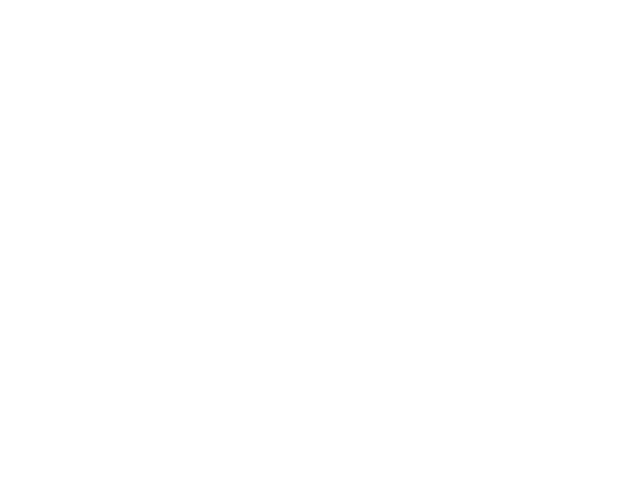

In [13]:
plt.clf()

In [14]:
#IMAGE = 'test3.png'
im = plt.imread('./test_img/' + IMAGE)

implot = plt.imshow(fixDisplayImageShape(im))

new_shape_MEE = np.transpose(result_MEE)
new_shape_iBUG = np.transpose(result_iBUG)

plt.scatter(x=new_shape_MEE[0], y=new_shape_MEE[1], c='b', s=5)
plt.scatter(x=new_shape_iBUG[0], y=new_shape_iBUG[1], c='r', s=5)

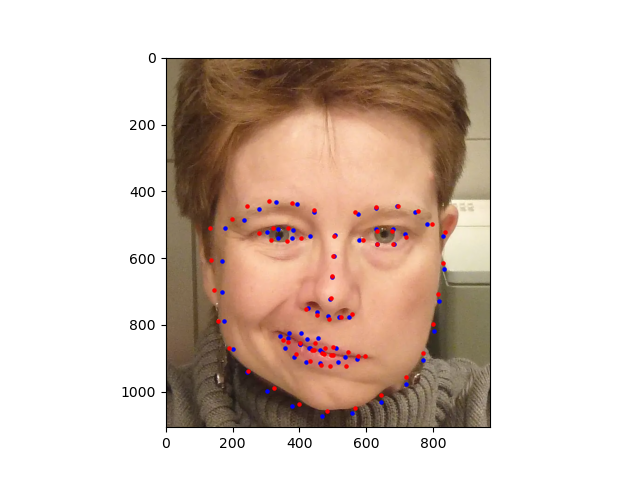

In [15]:
plt.show()